# PageRank and network visualisation on FT-ICR-MS data
In this notebook we will perform network analysis on an FT-MS dataset. This involves creating a network in which the molecular formula present in a sample are the nodes, and the reactions that can happen between them on the connectors (i.e. edges in network terminology).

Once we have created a theoretical network, we can perform analysis of the information flow in that network using Google's [PageRank](https://en.wikipedia.org/wiki/PageRank) algorithm and make a pretty visualisation of the network using open-source software such as [Cytoscape](https://cytoscape.org). We can also use the reverse PageRank algorithm to infer reaction probabilties from our network. 

This notebook will be divided in five parts.
* Part 1: Network creation and PageRank.
*  Part 2: Cytoscape visualisation of PageRank network.
*  Part 3: PageRank with defined probabilities.
*  Part 4: Reverse PageRank
*  Part 5: Summary

## Part 1: Network creation and PageRank

PageRank was an algorithm developed at Stanford University by Larry Page and Sergey Brin in 1996 and used by Google in order to rank search engine results. The algorithm simulates what would happen to a hypothetical internet user who types in a random URL and then moves to other websites by clicking links. The internet user has an equal probability of clicking any link on a website. If the user gets to a website with no links, then they have an equal probability of visiting any website on the internet by typing in another random URL. The outcome of the algorithm is a ranking of webpages by the probability that the user is currently viewing them. The probability of each website is proportional to the total probability of the other websites which are linking to it. 

The algorithm employs a network in which websites are nodes and links to other websites are edges. A simple depiction of the PageRank network is shown below (Image Credit: Felipe Micaroni Lalli, license CC 2.5). In this depiction the faces are websites and the pointing hands are links. The size of each face corresponds to the probability returned by the PageRank algorithm. 


![Author: Felipe Micaroni Lalli](PageRank_Wiki.png "Simple depiction of PageRank algorithm. Author: Felipe Micaroni Lalli, used under CC 2.5")

### PageRank and chemical networks

This same principle can be applied to a chemical network in which nodes are molecules and edges are reactions. For example the node 'C6H10O7' links to 'C5H10O5' by a decarboxylation reaction (-CO2) and to 'C6H12O7' by a hydrogenation reaction (+H2). Theoretically, we can define whatever reactions we want as connectors between our nodes. In this notebook we will limit the reactions to (de)methylation +-CH3, (de)hydrogenation +-H2, (de)hydration +-H2O, oxidation +O, reduction -O and decarboxylation -CO2. 

Running the PageRank algorithm on a network set up in this way will give us the probability of a molecule in the network. Since we are working from empirical data, we know all the molecules in our network exist, so this probability can instead by interpreted as the most probable relative abundance of the molecule in our network. This is based on the assumption that (i) all reactions in our network are equally likely, (ii) the network is closed (only the formula that we have detected can be nodes), and (iii) the reactions in our network are constantly happening at a rate proportional to the node size.

These assumptions are clearly not realistic, however analysis of information flow through a closed network formed by our data is still interesting and worth undertaking. Firstly, by altering the reactions we allow to occur, we can see how predicted abundances change and by comparing this to empirical abundance data rule out the existence of certain reactions. This is covered in Part 3: PageRank with defined probabilities. Taking this further, it is also possible to set PageRank up as an optimisation problem, in which we do not assume that all reactions are equally likely to happen, and instead optimise the probability of each reaction in our network so that the PageRank scores best match empirical relative abundance data. In this way we can use PageRank to learn about the reaction conditions in our system, this is explored in part 4: reverse PageRank.

### The mathematics of PageRank

A good explanation of the mathematics of PageRank can be found in Week 5 of the following free course: https://www.coursera.org/learn/linear-algebra-machine-learning

Briefly, PageRank can be understood as a linear algebra problem in which we are trying to find the eigenvector of matrix $L$ with an eigenvalue of 1. 
Matrix L is a numerical depiction of our network with shape (N,N) in which N is the number of nodes in the network. 

$L$ has the form: 

$$ L = \begin{bmatrix}
L_{A→A} & L_{B→A} & L_{C→A} & L_{D→A} & L_{E→A} & L_{F→A} \\
L_{A→B} & L_{B→B} & L_{C→B} & L_{D→B} & L_{E→B} & L_{F→B} \\
L_{A→C} & L_{B→C} & L_{C→C} & L_{D→C} & L_{E→C} & L_{F→C} \\
L_{A→D} & L_{B→D} & L_{C→D} & L_{D→D} & L_{E→D} & L_{F→D} \\
L_{A→E} & L_{B→E} & L_{C→E} & L_{D→E} & L_{E→E} & L_{F→E} \\
L_{A→F} & L_{B→F} & L_{C→F} & L_{D→F} & L_{E→F} & L_{F→F} \\
\end{bmatrix}
$$

In this example N = 6, and A,...,F are the identities of molecular formula in our sample.
Each column represents the probability of a given formula reacting to form the other formulas, and sum to one. 
E.g. The first column is the probabilities of A reacting to form A,B,C,D,E,F. 
The rows determine how likely you are to arrive at a formula from any other, and do not need to sum to one. 

To find the eigenvector with an eigenvalue of one, we could do full eigen decompisition, but this is slow for large matrices and in this case we only care about the principal eigenvector. Instead we can use the [power iteration method](https://en.wikipedia.org/wiki/Power_iteration) in which we repeatedly multiply matrix $L$ by vector $r$ until $r$ converges on the principal eigenvector. 

In practice, we are going to make one further alteration to this algorithm to include a damping factor, $d$. This factor represents the probability that instead of a defined reaction occuring, one formula becomes any other formula in our system at random. If we set d == 0, this means that all information flow in our network is entirely random, and if d == 1, then only defined reactions occur. Why do this? It prevents inflation of the PageRank score for a formula in our network that does not link to any other formula. Without the damping factor, this formula will obtain a high page rank score as once a reaction forms it, there can be no further reactions in the network. Including the damping factor our new network matrix, $M$, looks like this: 

$$ M = d \, L + \frac{1-d}{N} \, J $$

Where $J$ is an N by N matrix of ones. 

This can be done in Pykrev using the function **page_rank**.

In the following code we will run the PageRank algorithm on formula in a complex mixture taken from peat soil dissolved organic matter.

In [1]:
# First import the libraries we need
import pandas as pd
import numpy as np
import numpy.linalg as la
import pykrev as pk
import random
from matplotlib import pyplot as plt
from scipy import stats
%matplotlib inline
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
# Read in an example dataset using read_corems
dataset = pd.read_csv('..\example_data\corems_output.csv')
msTuple = pk.read_corems(dataset)
intensityArray = msTuple.intensity
intensityNorm = pk.normalise_intensity(intensityArray)
formulaList = msTuple.formula
formulaMass = pk.calculate_mass(formulaList) # Compute the exact monoisotopic mass of each formula in the dataset
N = len(formulaList)

In [3]:
"""The reactions that can occur are defined below """
reactionDict = {
## decarboxylation
'decarboxylation': -pk.calculate_mass(['CO2']),
## methylation 
'methylation': pk.calculate_mass(['CH2']),
## demethylation 
'demethylation': -pk.calculate_mass(['CH2']),
## hydrogenation
'hydrogenation': pk.calculate_mass(['H2']),
## dehydrogenation
'dehydrogenation': -pk.calculate_mass(['H2']),
## hydration 
'hydration': pk.calculate_mass(['H2O']),
## dehydration 
'dehydration': -pk.calculate_mass(['H2O']),
# oxidation 
'oxidation': pk.calculate_mass(['O']),
# reduction
'reduction': -pk.calculate_mass(['O'])
}

We can run the page rank algorithm using the **page_rank** function in PyKrev.

In [4]:
r = pk.page_rank(msTuple, reactionDict = reactionDict, d = 0.9, tol = 0.01)

22 iterations to convergence.


The code below shows how we would do it in Python without the PyKrev function.

In [5]:
## Create the matrix L 
L = np.zeros([N,N])
for j in range(N):
    for reactionType in reactionDict.keys():
        # find possible matches, use np.round to account for rounding errors
        matchIndex = np.where(np.round(formulaMass,8) == np.round((formulaMass[j] + reactionDict[reactionType]),8))
        # if a match is found
        if len(matchIndex[0]) > 0:
            L[matchIndex,j] = 1
    ## normalise the probabilities so they sum to one
    if sum(L[:,j]) > 0:
        L[:,j] = L[:,j]/sum(L[:,j])
    ## if the column sums to zero set to 1/N
    else: 
        L[:,j] = 1/N
# run the pageRank algorithm to convergence
r = 100 * np.ones(N) / N # Sets up the probability vector
d = .9 # Damping factor - feel free to play with this parameter after running the code once.
M = d * L + (1-d)/N * np.ones([N, N]) # np.ones() is the J matrix, with ones for each entry.
lastR = r
r = M @ r
i = 0
while la.norm(lastR - r) > 0.01 :
    lastR = r
    r = M @ r
    i += 1
print(str(i) + " iterations to convergence.")

22 iterations to convergence.


Let's look at some statistics describing the page rank scores.

The highest page rank formula is
C10H20O3
With a probability at convergence of
0.10373265646293117
The top 10 page rank formula are: 
C8H13N1O6
C9H14O4
C7H11N1O6
C18H30O6
C8H13N1O5
C9H16O4
C9H16O3
C9H18O3
C8H16N2O4
C10H20O3
The correlation between pagerank and peak intensity is
0.3413293800313798
The correlation between pagerank and formula mass is
-0.4016422200325277
A histogram of probabilities at d == 0.9


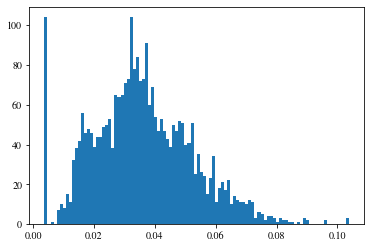

In [6]:
argmax = np.argmax(r)
print('The highest page rank formula is')
print(formulaList[argmax])
print('With a probability at convergence of')
print(max(r))
print('The top 10 page rank formula are: ')
top_10_idx = np.argsort(r)[-10:]
for i in top_10_idx:
    print(formulaList[i])
print(f'The correlation between pagerank and peak intensity is')
print(stats.spearmanr(r,intensityNorm)[0])
print(f'The correlation between pagerank and formula mass is')
print(stats.spearmanr(r,formulaMass)[0])
print(f'A histogram of probabilities at d == {d}')
hist = plt.hist(r, bins = 100)

## Part 2: Create a graphML representation of the reaction network which can be visualised using Cytoscape

PageRank is only informative if we have a graphical depiction of what our reaction network looks like. To do that we will use the ```networkx``` python library to create a .graphML format of our reaction network. We can then visualise this network using the free and open source [Cytoscape](https://cytoscape.org). networkx can be installed using ```pip install networkx``` and Cytoscape can be installed from the website. There is thorough and helpful documentation for both software packages which I encourage you to refer to if you get stuck.

We will use networkx to create a representation of our reaction network which we can load into Cytoscape. We will add annotation to the edges in the network so they are labelled by reaction type, and we will annotate the nodes in the network so they are labelled with their corresponding pageRank values and peak intensities.

This can be done using the **reaction_network** function in PyKrev.

In [7]:
G, reactionCounts = pk.reaction_network(msTuple, reactionDict = reactionDict, filePath = 'FTICRMS.graphML', fileFormat = 'graphml', nodeAnnotations = {"pageRank" : r, "peakIntensity" : intensityArray}, roundVal = 8)
print(reactionCounts)

Number of nodes in graph:
2775
Number of edges in graph
18031
{'decarboxylation': 1711, 'methylation': 2178, 'demethylation': 2178, 'hydrogenation': 2083, 'dehydrogenation': 2083, 'hydration': 1869, 'dehydration': 1869, 'oxidation': 2030, 'reduction': 2030}


**Import the network file we just saved into cytoscape and do further stylistic changes and network analysis. A brief video tutorial on using cytoscape is show below.**

*Note: if the video doesn't load, it is available as an unlisted video on YouTube: https://www.youtube.com/watch?v=CQeIEZ6-e50*

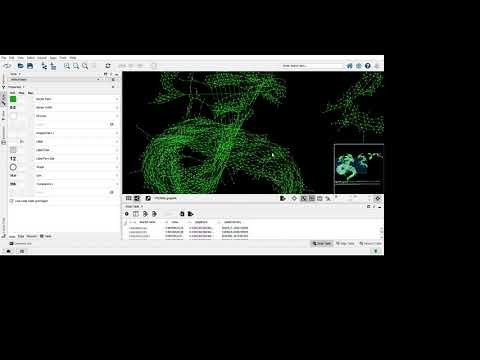

In [8]:
from IPython.display import YouTubeVideo
YouTubeVideo('CQeIEZ6-e50', width=600,height=300)

## Part 3: Page Rank with defined probabilities

PageRank provides an alternative to peak intensities for calculating relative formula abundance. 

Assumptions:
1. all reactions in our network are equally likely
2. the network is closed (only the formula that we have detected can be nodes)
3. the reactions in our network are constantly happening at a rate proportional to their node size

If we have prior knowledge of the system, we do not have to assume (1) that all reactions are equally likely. 

It is possible to define reaction probabilities when creating the transition matrix L. 

We can then see how our pagerank scores change under changing reaction probabilities.

This is done below using the **page_rank** function in PyKrev and a reaction weights dictionary. (Note: the edge weights are still normalised to one, so increasing the weighting of one type of reaction will only affect edge probabilities if there are multiple edges from a single node.)

In [9]:
reactionWeights = {
## set decarboxylation to be tjree times as likely as the other reactions
'decarboxylation': 3,
## methylation 
'methylation': 1,
## demethylation 
'demethylation': 1,
## hydrogenation
'hydrogenation': 1,
## dehydrogenation
'dehydrogenation': 1,
## hydration 
'hydration': 1,
## dehydration 
'dehydration': 1,
# oxidation
'oxidation': 1,
# reduction
'reduction': 1
}

In [10]:
r = pk.page_rank(msTuple, reactionWeights = reactionWeights, d = 0.9, tol = 0.01)

24 iterations to convergence.


The highest page rank formula is
C9H18O3
With a probability at convergence of
0.2626275883903489
The top 10 page rank formula are: 
C17H28O5
C18H30O6
C10H18O4
C8H13N1O5
C9H14O4
C10H18O3
C9H16O4
C9H16O3
C10H20O3
C9H18O3
The correlation between pagerank and peak intensity is
0.2356079967161683
The correlation between pagerank and formula mass is
-0.4509049031531414
A histogram of probabilities at d == 0.9


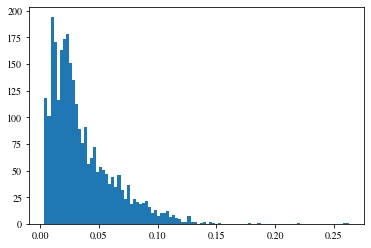

In [11]:
argmax = np.argmax(r)
print('The highest page rank formula is')
print(formulaList[argmax])
print('With a probability at convergence of')
print(max(r))
print('The top 10 page rank formula are: ')
top_10_idx = np.argsort(r)[-10:]
for i in top_10_idx:
    print(formulaList[i])
print(f'The correlation between pagerank and peak intensity is')
print(stats.spearmanr(r,intensityNorm)[0])
print(f'The correlation between pagerank and formula mass is')
print(stats.spearmanr(r,formulaMass)[0])
print(f'A histogram of probabilities at d == {d}')
hist = plt.hist(r, bins = 100)

## Part 4: Reverse Page Rank

Following on from the above, the PageRank algorithm can be inverted so that we infer the probability of edges (i.e. reactions) from already known node abundance (i.e. molecular formula relative intensity). This problem is known as Reverse PageRank and is a current area of research in data science. The problem has also been indirectly tackled in linear algebra research in mathematics, where it is known as a 'Prescribed Entry Inverse Eigenvalue Problem' in which the prescribed entries are zeros, and there is a constraint that the output matrix must be left-handed stochastic (so the columns sum to one). A few key publications tackling this problem are as follows: 
* https://www.sciencedirect.com/science/article/pii/S0024379503003938?via%3Dihub (2004)
* http://proceedings.mlr.press/v70/maystre17b.html (2017, image from paper below)
* https://epjdatascience.springeropen.com/articles/10.1140/epjds/s13688-020-00240-z (2020)

![Author: Lucas Maystre](choicerank.png " Depiction of choicerank algorithm. Author: Lucas Maystre, used under CC 2.5")


We are going to use the algorithm implemented in the last paper (Gábor Berend, 2020). The algorithm is implemented in Java so you will need to have the Java runtime installed to run the next code cell. For more instructions see: https://github.com/begab/reversePageRank

In [12]:
# First we need to save a copy of the file in the .gexf format with a 'weight' annotation corresponding to normalised peak intensities
G, reactionCounts = pk.reaction_network(msTuple, reactionDict = reactionDict, filePath = 'FTICRMS.gexf', fileFormat = 'gexf', nodeAnnotations = { "weight" : intensityNorm}, roundVal = 8)

Number of nodes in graph:
2775
Number of edges in graph
18031


In [13]:
# you will need to install the java runtime to execute the following code cell
!java -jar reversePageRank.jar FTICRMS.gexf

Network from file FTICRMS.gexf with 2775 vertices and 18031 edges read in.
EXITING BACKTRACK: Jump too small (alamin=1.5134351953989778E-7). Exiting and using xold. Value=-1.138457421911441
Line search could not step in the current direction. (This is not necessarily cause for alarm. Sometimes this happens close to the maximum, where the function may be very flat.)
The initial objective value improved from 1.992311 to 1.138457
The predicted edge transition probabilities were written into file output.log.


In the next code cell, we parse the output.log file that the reverse pagerank algorithm outputs to do the following: 
1. read in the 'learned' transitional probability matrix
2. read in the page rank scores of this optimised probability matrix and see how they compare to the peak intensities the algorithm was was trained on
3. look at the expected value of a reaction type in our system by averaging over all edge probabilities corresponding to a given reaction type and multiplying that value by the number of those reactions in the system. The probability of observing each reaction type if the system was sampled at random can then be calculated by dividing a given expected value by the sum of expected values for all reaction types.
    *  $E(reaction type) = \sum{reaction type} \times averageTransitionalProbability(reaction type)$
    
    * $p(reaction type) = \frac{E(reaction type)}{\sum{E(reaction type)}}$


In [14]:
#This dictionary is used to hold find average reaction values 
reverseValues = []
for v in  reactionDict.values():
    reverseValues.append(np.round(float(v),8))
reverseDict = dict((v,k) for k,v in zip(reactionDict.keys(),reverseValues))
# reaction Arrays is a dictionary which will hold the probabilities of each type of reaction in an array 
reactionArrays = reactionDict.fromkeys(reactionDict, np.array([]))
L2 = np.zeros([N,N])
r2 = []
import csv
with open('output.log') as csvfile:
    reader = csv.reader(csvfile, delimiter = '\t')
    for row in reader:
        # then it's a node
        if len(row) == 4:
            cindex = int(row[0])
            # save the page rank scores of the learned probability matrix
            r2.append(float(row[3]))
        # then it's a transition
        elif len(row) == 3:
            rform = row[1][2::]
            currentReaction = reverseDict[float(np.round(pk.calculate_mass([rform]) - pk.calculate_mass([formulaList[cindex]]), 8))] 
            reactionArrays[currentReaction] = np.append(float(row[2]),reactionArrays[currentReaction])
            matchIndex = formulaList.index(rform)
            L2[cindex,matchIndex] = float(row[2])
# recreate the learned probailty matrix
for i in range(N):
    if(np.sum(L2[i,:])) == 0:
        L2[i,:] = 1/N

Below we print some statistics about the page rank scores of the optimised probabiliy matrix

The highest page rank formula is
C6H8O7
With a probability at convergence of
0.032185
The top 10 page rank formula are: 
C8H6O6
C7H10O7
C6H6O6
C6H12O7
C6H8O6
C9H18O3
C8H16O3
C6H12O6
C6H10O7
C6H8O7
The correlation between pagerank and peak intensity is
0.6406822177718946
The correlation between pagerank and formula mass is
-0.5943066809340042

A histogram of page probabilities:


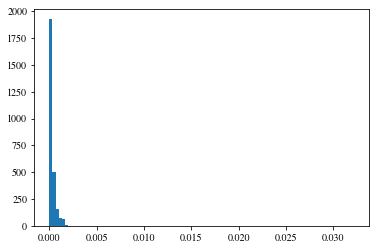


A box plot of reaction probabilities:


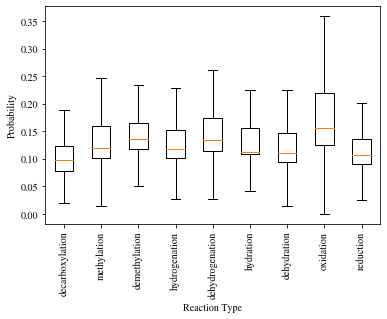


Average probability of each reaction following reverse PageRank:
decarboxylation = 0.11639615663354763
methylation = 0.14954279476584023
demethylation = 0.16582826721763083
hydrogenation = 0.14751726740278442
dehydrogenation = 0.15581176380220835
hydration = 0.1415799111824505
dehydration = 0.12749200160513643
oxidation = 0.1886149561576355
reduction = 0.13564029950738918


In [15]:
argmax = np.argmax(r2)
print('The highest page rank formula is')
print(formulaList[argmax])
print('With a probability at convergence of')
print(max(r2))
print('The top 10 page rank formula are: ')
top_10_idx = np.argsort(r2)[-10:]
for i in top_10_idx:
    print(formulaList[i])
print(f'The correlation between pagerank and peak intensity is')
print(stats.spearmanr(r2,intensityNorm)[0])
print(f'The correlation between pagerank and formula mass is')
print(stats.spearmanr(r2,formulaMass)[0])
print()
print(f'A histogram of page probabilities:')
hist = plt.hist(r2, bins = 100)
plt.show()
print()
print(f'A box plot of reaction probabilities:')
fig, ax = plt.subplots()
labels, data = [*zip(*reactionArrays.items())]  # 'transpose' items to parallel key, value lists
ax.boxplot(data, 0 , "")
ax.set_xticklabels(labels, rotation = 90)
ax.set_ylabel('Probability')
ax.set_xlabel('Reaction Type')
plt.show()
print()
print('Average probability of each reaction following reverse PageRank:')
for key in reactionArrays.keys():
    print(f'{key} = {reactionArrays[key].mean()}')

## Part 5: Summary

To summarise: 
1. PageRank scores offer an alternative to peak intensities for ranking molecular formula by importance. 
2. PageRank with defined probabilities allows us to simulate how formula rankings would change under different reaction conditions. 
3. Reverse PageRank enables us to learn reaction probabilities from known formula abundance. 


Let me know if you have any questions or feedback on this approach by email.